## Imports

In [1]:
from DataProvider import DataProvider
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Data

In [2]:
dataProvider = DataProvider()

[Getting raw data...]
[Preprocessing...]
[Data Provider ready]


In [3]:
train, test = dataProvider.get_train_test_sets(0.7)

In [4]:
x_train, y_train = dataProvider.get_x_and_y(train)
x_test, y_test = dataProvider.get_x_and_y(test)

# LSTM model

In [5]:
lstm_model = tf.keras.Sequential()
lstm_model.add(layers.LSTM(50, activation='relu', input_shape=(11, 1)))
lstm_model.add(layers.Dense(1))

In [6]:
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])

## Train

In [7]:
lstm_model.fit(x_train, y_train, epochs=150, verbose=1)

Epoch 1/150
5/5 [==============================] - 1s 5ms/step - loss: 24310.3965 - accuracy: 0.0000e+00
Epoch 2/150
5/5 [==============================] - 0s 4ms/step - loss: 12517.6436 - accuracy: 0.0000e+00
Epoch 3/150
5/5 [==============================] - 0s 4ms/step - loss: 9389.6113 - accuracy: 0.0000e+00
Epoch 4/150
5/5 [==============================] - 0s 4ms/step - loss: 4861.5220 - accuracy: 0.0000e+00
Epoch 5/150
5/5 [==============================] - 0s 4ms/step - loss: 1924.9591 - accuracy: 0.0000e+00
Epoch 6/150
5/5 [==============================] - 0s 4ms/step - loss: 1185.9481 - accuracy: 0.0000e+00
Epoch 7/150
5/5 [==============================] - 0s 4ms/step - loss: 1407.7932 - accuracy: 0.0000e+00
Epoch 8/150
5/5 [==============================] - 0s 4ms/step - loss: 1061.2638 - accuracy: 0.0000e+00
Epoch 9/150
5/5 [==============================] - 0s 4ms/step - loss: 1034.6953 - accuracy: 0.0000e+00
Epoch 10/150
5/5 [==============================] - 0s 4ms/ste

## Eval

In [8]:
def MSE(x, y):
    mse = (np.square(x - y)).mean(axis=-1)
    return mse

In [9]:
predictions = lstm_model.predict(x_test, verbose=1)
predictions = predictions.reshape((predictions.size))
print(f"MSE: {MSE(predictions, y_test)}")

2/2 [==============================] - 0s 3ms/step
MSE: 772.1788652325904


# Visualization

In [10]:
from sklearn.linear_model import LinearRegression
import pandas as pd
# Naive model
class LinearRegressionModel:
    def __init__(self):
        self._model = LinearRegression()
    
    def fit(self, x, y):
        self._model.fit(x, y)
    
    def predict(self, x):
        return self._model.predict(np.array(x).reshape((-1, 1)))

In [49]:
def plot_comparison(artist, input, label, future_points=5):
    # Naive model
    naive_input = input.reshape((11))
    naive_model = LinearRegressionModel()
    naive_model.fit(np.array(range(naive_input.size)).reshape(-1, 1), naive_input)
    naive_predictions = pd.Series(naive_model.predict(x) for x in range(len(input) + future_points))
    
    # LSTM model
    lstm_predictions = [x for x in input]
    for n in range(future_points):
        reshaped_input = np.array(lstm_predictions[-11:]).reshape((1, 11, 1))
        prediction = lstm_model.predict(reshaped_input)[0]
        lstm_predictions.append(prediction)

    plt.figure(figsize=(15,8))
    plt.locator_params(axis='y', nbins=20)
    plt.title(f"Artist: {artist}")
    plt.xlabel("Week [ordered Number]")
    plt.ylabel("Play time [minutes]")
    # Naive prediction
    plt.plot(naive_predictions, label="Naive prediction", marker='o', color='green')
    # LSTM prediction
    plt.plot(lstm_predictions, label="LSTM prediction", marker='o', color='blue')
    # Past and current
    plt.plot(pd.Series(input.reshape(11)), label="Actual data", marker='o', color='black')
    # Future
    plt.plot([len(input) - 1, len(input)], [input[-1][0], label], label="Future", marker='o', color='red')
    plt.text(len(input)/2, naive_input[2],
             f"MSE loss for Naive: {MSE(label, naive_predictions[len(naive_predictions)-future_points]):.2f}\n"
           + f"MSE loss for LSTM: {MSE(label, lstm_predictions[-future_points]):.2f}",
             style='italic', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
    plt.grid()
    plt.legend()


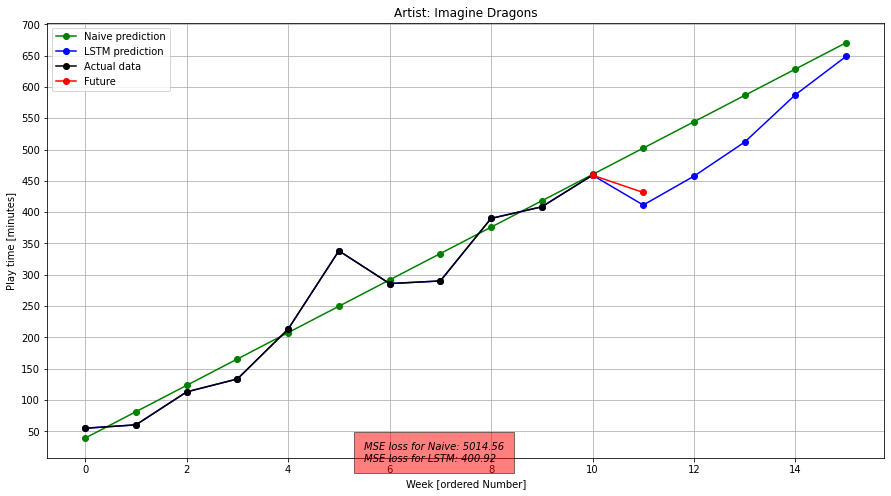

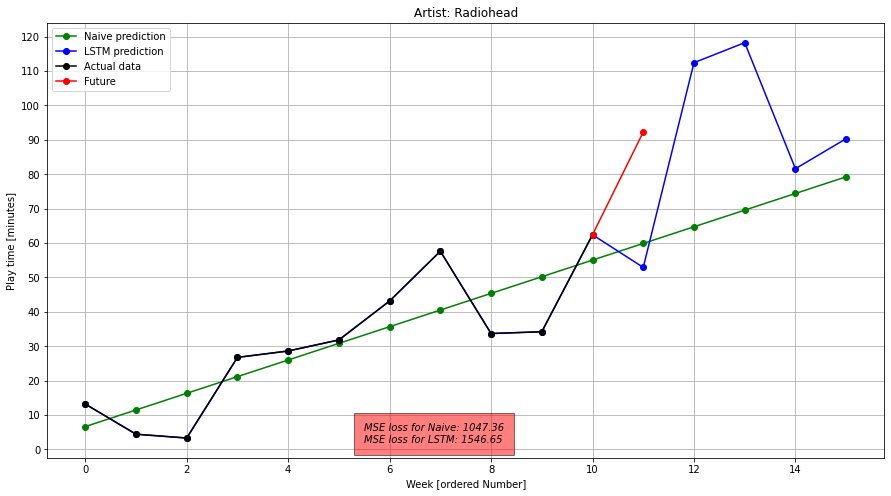

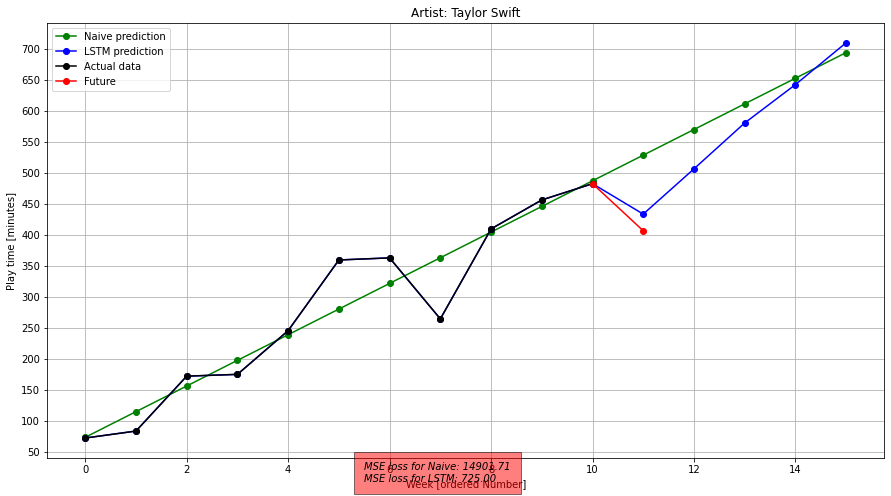

In [50]:
artists_to_display = ['Imagine Dragons', 'Radiohead', 'Taylor Swift']

for artist in artists_to_display:
  x, y = dataProvider.get_x_and_y([artist])
  plot_comparison(artist, x[0], y[0])